In [1]:
cd ../

/Users/nguyen/projects/ab-framework


In [19]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

# import custom scripts
from src.plot import *
from src.data import *
from src.stats import *

%matplotlib inline
plt.style.use('ggplot')

# The Math Behind AB Testing

## Outline
1. Set up the experiment
  * What is the goal? 
  * What is the metric and how much of an increase is worth the change? 
  * How much statistical power and level of significance do you need? Typically 80% and 0.05 are used respectively.
2. Set up a control group and test group by selecting users at random
3. Run the test -> Record the success rate for each group
4. Plot the distribution of the difference between the two samples
5. Measure the probability of getting the result of the test group and the confidence interval. Check to see if there is enough statistical power and that the level of significance is achieved.
6. Consider other tradeoffs and decide if the change should be launched

## Set up the experiment

The goal of running an AB test is to evaluate if a change in a website will lead to improved performance in a specific metric. You may decide to test very simple alternatives such as changing the look of a single button on a webpage or testing different layouts and headlines. You could also run an AB test on multi-step processes which may have many differences. Examples include signing up a new user or processing the sale on an online marketplace. There are many articles on the web about AB testing but very few actually get into the math. So, the goal of this article is to provide a walkthrough of a typical AB test with equations and plots at each step.

## Variables

* Sample size
* Baseline conversion rate
* Minimum detectable effect
* Desired statistical power
* Confidence level or level of significance

## Control Group A and Test Group B
Typically, users are randomly selected and assigned to either a control group or a test group, and the total number of users participating in the A/B test make up a small percentage of the total amount of users. For this article, we will run an A/B test for a hypothetical company that is trying to get users to sign up for a premium account.

Initially, we will collect 10000 samples for each group and serve the current signup page to the control group and a new signup page to the test group.

## Run the Test

Since this is just a hypothetical case, let's generate some fake data. In real-world applications, you will have to wait the amount of time needed to gather the data.

In [82]:
# A is control; B is test
N_A = 1000
N_B = 1000

# bcr: baseline conversion rate
# d_hat: difference in a metric between the two groups, sometimes referred to as minimal detectable effect or lift
bcr = 0.10
d_hat = 0.02

In [83]:
ab_data = generate_data(N_A, N_B, bcr, d_hat)

In [84]:
ab_data.head()

,converted,group
0,0,B
1,1,B
2,1,A
3,0,A
4,0,B


Let's look at some of the metrics that are immediately available. First, let's see how many rows of data we have.

In [85]:
ab_data.shape

(2000, 2)

Next, let's see how many users from each group converted.

In [86]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

In [87]:
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(102, 130)

In [88]:
A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(988, 1012)

In [89]:
A_cr, B_cr = A_converted / A_total, B_converted / B_total
A_cr, B_cr

(0.10323886639676114, 0.12845849802371542)

The above result matches our parameters that we used to set up the test. Keep in mind that you will not be able to set how much lift you would see in the test group in real-world applications. However, you do have to decide how many samples you will need for the test and you will probably know the baseline conversion rate.

If you observe the conversion rate for both groups, you find that the new signup page resulted in an improvement of 2%. This is good news, but how can you demonstrate that this result is statistically significant.

## Compare the Two Samples

In [90]:
B_cr * A_total

126.91699604743084

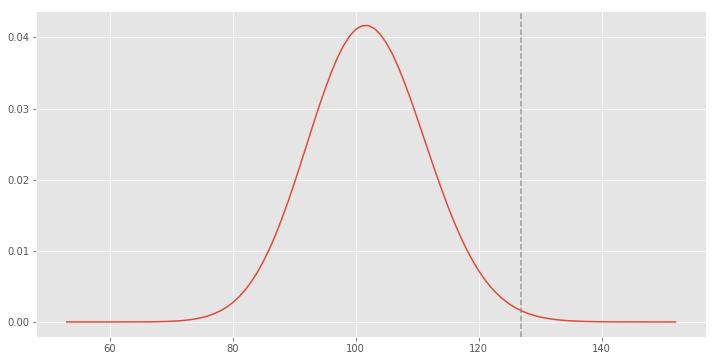

In [91]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.plot(x, y)
ax.axvline(x=B_cr * A_total, c='grey', alpha=0.75, linestyle='--')

If we plot the binomial distribution that corresponds to the control group we would get the plot above in red. If we want to evaluate the probability of getting the result from the test group based on the binomial distribution from the control group, we would get the following:

In [94]:
scs.binom(A_total, A_cr).pmf(126)

0.0019842442478091634

That is a very low probability. If we are comparing this to a significance level, typically referred to as alpha, we would say that the result is drastically lower than 5% or even 1%. In other words, there was a 0.2% chance that we would have seen this result. Is this enough evidence of statistical significance? Let's get into statistical power.

### Statistical power
We now need to consider the confidence level of the test. We will plot the null hypothesis and the alternative hypothesis.

* The null hypothesis is that the change made for the test group **would result in no change** in the conversion rate.
* The alternative hypothesis is that the change for the test group **would result in a detectable change** in the conversion rate.

We can represent the null hypothesis by plotting the distribution of the difference between the control and test group. According to the Udacity course, the distribution will be normal with a mean of zero and a standard deviation equal to the pooled standard error. This is an application of the central limit theorem. 

According to statisticshowto:
The Central Limit Theorem states that the sampling distribution of the sample means approaches a normal distribution as the sample size gets larger — no matter what the shape of the population distribution.


We can prove this by the following: 
Our control and test groups are samples taken from a population. 
We are taking the mean of each group's distribution, which in this case is binomial, and we are finding the difference Let's demonstrate if this distribution is truly normal. We can use our data generation script to repeat this process 1000 times. We will set the variable, `d_hat`, to zero to represent the case where the null hypothesis is true.

### 

In [162]:
results = []
for idx in range(1000):
    ds = generate_data(N_A=100, N_B=100, bcr=0.10, d_hat=0)
    A_group = ds[ds['group'] == 'A']
    B_group = ds[ds['group'] == 'B']
    A_rate = A_group['converted'].sum() / len(A_group)
    B_rate = B_group['converted'].sum() / len(B_group)
    d_rate = B_rate - A_rate
    results.append(d_rate)

KeyboardInterrupt: 

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  2.,  4., 12.,
        12., 14., 13., 19., 23., 35., 39., 39., 52., 51., 49., 53., 63.,
        46., 56., 66., 49., 51., 48., 35., 43., 25., 16., 17., 19., 12.,
         6.,  8.,  6.,  2.,  4.,  4.,  2.,  1.,  0.,  0.,  1.]),
 array([-0.16185897, -0.15575311, -0.14964724, -0.14354138, -0.13743551,
        -0.13132964, -0.12522378, -0.11911791, -0.11301204, -0.10690618,
        -0.10080031, -0.09469444, -0.08858858, -0.08248271, -0.07637685,
        -0.07027098, -0.06416511, -0.05805925, -0.05195338, -0.04584751,
        -0.03974165, -0.03363578, -0.02752991, -0.02142405, -0.01531818,
        -0.00921232, -0.00310645,  0.00299942,  0.00910528,  0.01521115,
         0.02131702,  0.02742288,  0.03352875,  0.03963462,  0.04574048,
         0.05184635,  0.05795221,  0.06405808,  0.07016395,  0.07626981,
         0.08237568,  0.08848155,  0.09458741,  0.10069328,  0.10679915,
         0.11290501,  0.11901088,  0.12511674,  0.13122261,

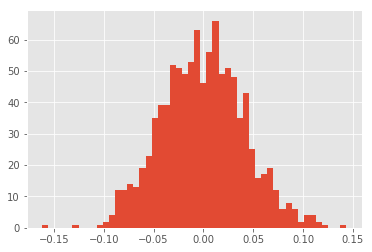

In [130]:
fig, ax = plt.subplots()
ax.hist(results, bins=50)

In [123]:
n = N_A + N_B
bcr = A_converted / A_total
d_hat = B_converted / B_total - bcr

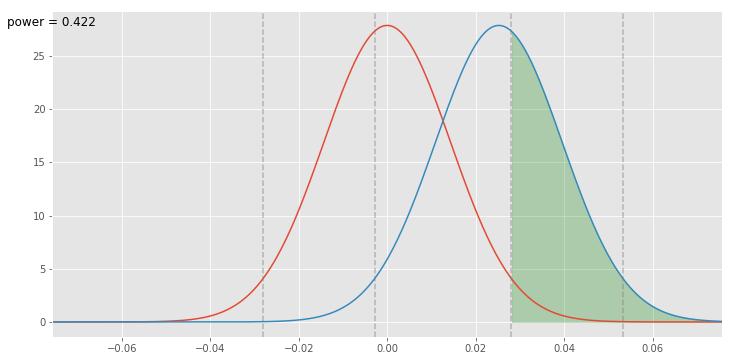

In [125]:
abplot(n, bcr, d_hat, show_power=True)

## Consider Tradeoffs

## Common Interview Questions